# **Proyek Machine Learning: Sistem Rekomendasi Buku**


Pada proyek ini akan dikembangkan sistem rekomendasi buku dengan metode content-based filtering menggunakan teknik cosine similarity dan collaborative filtering menggunakan algoritma KNN. Langkah-langkah yang dilakukan dalam proyek ini sebagai berikut.

## **Data Understanding**

Data yang digunakan dalam proyek ini merupakan data sekunder yang diperoleh dari Kaggle dengan nama dataset yaitu 'goodreads-books'. Data tersebut dapat diakses melalui tautan berikut:
https://www.kaggle.com/datasets/jealousleopard/goodreadsbooks/data


Berdasarkan informasi dari Kaggle, variabel-variabel pada dataset adalah sebagai berikut:
1. bookID: nomor identifikasi unik untuk setiap buku.
2. title: judul buku.
3. author: penulis buku tertentu.
4. average_rating: peringkat rata-rata untuk setiap buku (0-5)
5. ISBN: momor yang memberi tahu informasi tentang buku, secara lebih spesifik tentang edisi dan penerbit
6. isbn13: format baru untuk ISBN, diterapkan pada tahun 2007 dengan 13 digit
7. language_code: bahasa buku
8. num_pages: jumlah halaman buku
9. ratings_count: banyaknya rating yang diberikan untuk setiap buku
10. text_reviews_count: banyaknya ulasan yang diberikan oleh pengguna untuk masing-masing buku.
11. publication_date: waktu buku dipublikasi
12. publisher: penerbit buku

### **Data Loading**

Agar dataset lebih dipahami, perlu dilakukan Data Loading. Pertama, disiapkan terlebih dahulu library yang dibutuhkan.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from scipy import stats
from wordcloud import WordCloud, STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score

Dataset yang digunakan disimpan di google drive. Untuk bisa mengakses dataset tersebut, terlebih dahulu dihubungkan google drive dan google colab.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Kemudian data diunggah dari google drive ke google colab menggunakan kode berikut.

In [ ]:
book = pd.read_csv('/content/drive/MyDrive/IdCamp/Dataset/goodreads_books.csv')
book.head()

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_of_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,043965548X,9780439655484,eng,435,2339585,36325,5/1/2004,Scholastic Inc.
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,0439682584,9780439682589,eng,2690,41428,164,9/13/2004,Scholastic


Dilakukan pengecekan dimensi dataset.

In [ ]:
book.shape

(11127, 12)

Berdasarkan output kode di atas, diketahui bahwa:

1. Ada 11127 baris (jumlah pengamatan) dalam dataset.
2. Terdapat 12 kolom dalam dataset.

Selanjutnya, dilakukan pengecekan informasi dari dataset.

In [ ]:
book.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                  int64
language_code          object
num_of_pages            int64
ratings_count           int64
text_reviews_count      int64
publication_date       object
publisher              object
dtype: object

Berdasarkan output kode di atas, diketahui bahwa:

1. Ada 6 kolom dengan tipe data object, yaitu title, authors, isbn, language_code, publication_date, dan publisher
2. Ada 1 kolom dengan tipe data float64, yaitu average_rating.
3. Ada 5 kolom dengan tipe data int64, yaitu book_id, isbn13, num_of_pages, rating_count, dan text_reviews_count.

Kolom dengan tipe data object merupakan categorical features (fitur kategori atau fitur non numerik). Sedangkan, kolom kolom bertipe data float64 dan int64 (selain charge) merupakan fitur numerik. Adapun kolom charge adalah target dalam prediksi ini.

Semua kolom atau fitur pada dataset dapat digunakan untuk membangun sistem rekomendasi. Namun, pada proyek ini, hanya akan digunakan fitur berikut:                 
1. title                  
2. authors                
3. average_rating        
4. language_code          
5. num_of_pages            
6. ratings_count           
7. text_reviews_count                  

Lebih lanjut:
1. Fitur 'title', 'authors', dan 'language_code' digunakan untuk mengembangkan sistem rekomendasi dengan teknik cosine similarity.
2. Fitur 'title', 'average rating', 'num_of_pages',  'ratings_count', dan    'text_reviews_count' digunakan untuk mengembangkan sistem rekomendasi dengan algoritma KNN.

Oleh karena itu, fitur-fitur yang tidak digunakan akan dihilangkan menggunakan fungsi drop() dengan mengimplementasikan kode berikut.

In [ ]:
book.drop(columns=['bookID','isbn','isbn13','publisher','publication_date'], axis=1, inplace=True)
book.shape

(11127, 7)

Terlihat dataset baru terdiri dari 11127 record (jumlah pengamatan) dan 7 kolom.

### **Data Assesing dan Data Cleaning**

Selanjutnya, dilakukan proses Data Assesing yang meliputi pengecekan deskripsi statistik, unique value, data duplikat, missing value, dan outlier. Data cleaning yang dilakukan menyesuaikan hasil dari data assesing.

#### Deskripsi Statistik

Pengecekan deskripsi statistik dikenakan pada fitur numerik dengan mengimplementasikan kode dibawah ini.

In [ ]:
book.describe()

,average_rating,num_of_pages,ratings_count,text_reviews_count
count,11127.000000,11127.000000,1.112700e+04,11127.000000
mean,3.933631,336.376921,1.793641e+04,541.854498
std,0.352445,241.127305,1.124794e+05,2576.176608
min,0.000000,0.000000,0.000000e+00,0.000000
25%,3.770000,192.000000,1.040000e+02,9.000000
50%,3.960000,299.000000,7.450000e+02,46.000000
75%,4.135000,416.000000,4.993500e+03,237.500000
max,5.000000,6576.000000,4.597666e+06,94265.000000


Deskripsi statistik pada output kode di atas meliputi:
1. Count adalah jumlah sampel pada data.
2. Mean adalah nilai rata-rata.
3. Std adalah standar deviasi.
4. Min yaitu nilai minimum setiap kolom.
5. 25% adalah kuartil pertama. Kuartil adalah nilai yang menandai batas interval dalam empat bagian sebaran yang sama.
6. 50% adalah kuartil kedua, atau biasa juga disebut median (nilai tengah).
7. 75% adalah kuartil ketiga.
8. Max adalah nilai maksimum.

Lebih lanjut, berdasarkan output kode di atas, diketahui bahwa:
- Nilai minimum fitur 'average_rating' dan 'ratings_count' adalah 0, yang berarti terdapat buku yang tidak dinilai maupun di-review oleh pengguna goodreads.
- Nilai minimum fitur 'num_of_pages' adalah 0, yang berarti ada buku tanpa halaman.
- Nilai minimum fitur 'text_reviews_count' adalah 0, yang berarti ada buku tanpa review (berupa teks) yang diberikan oleh pengguna goodreads.

Berikut ini diimplementasikan kode untuk mengecek banyaknya record (pengamatan) yang mengandung nilai-nilai minimum tersebut.

In [ ]:
features_with_zero_value = ['average_rating','ratings_count','text_reviews_count','num_of_pages']

for feature in features_with_zero_value:
  print(f"number of books with 0 {feature}: {len(book[book[feature]==0])}")

number of books with 0 average_rating: 26
number of books with 0 ratings_count: 81
number of books with 0 text_reviews_count: 625
number of books with 0 num_of_pages: 76


Buku-buku dengan 'average_rating', 'ratings_count', dan 'num_of_pages' bernilai nol perlu dihilangkan karena mempengaruhi performa model. Lebih lanjut, buku-buku dengan 'text_reviews_count' bernilai 0 tidak harus dihilangkan karena memungkinkan bagi pengguna untuk memberikan penilaian rating tanpa memberi ulasan teks. Oleh karena itu, diimplementasikan kode berikut.

In [ ]:
book = book.drop(book.index[book['average_rating'] == 0])
book = book.drop(book.index[book['ratings_count'] == 0])
book = book.drop(book.index[book['num_of_pages'] == 0])
book.shape

(10971, 7)

Diperoleh dataset terbaru yang terdiri dari 10970 record (total pengamatan) dan 7 kolom.

#### Unique Value

Dilakukan pengeceken unique value dari fitur kategori dengan mengimplementasikan kode berikut.

In [ ]:
for column in book.columns:
  if (book[column].dtypes == 'object'):
    print(f"Banyak unique value dari fitur '{column}': {len(book[column].unique())}")

Banyak unique value dari fitur 'title': 10214
Banyak unique value dari fitur 'authors': 6548
Banyak unique value dari fitur 'language_code': 26


Lebih lanjut, dilakukan pengecekan unique value dari fitur 'author' dan 'langugae_code' sebagai berikut.

##### Fitur 'author'

In [ ]:
print(f"Unique value dari fitur 'authors': {book['authors'].unique()}")

Unique value dari fitur 'authors': ['J.K. Rowling/Mary GrandPré' 'J.K. Rowling' 'W. Frederick Zimmerman' ...
 'C.S. Lewis/Ana Falcão Bastos'
 'C.S. Lewis/Pauline Baynes/Ana Falcão Bastos'
 'William T. Vollmann/Larry McCaffery/Michael Hemmingson']


Berdasarkan output kode diatas, diketahui terdapat 'authors' yang terdiri lebih dari satu orang, sebagai contoh yaitu 'J.K. Rowling/Mary GrandPré'. Namun, jika ditelusuri lebih lanjut sebanarnya hanya nama pertama yang merupakan penulis buku, nama kedua atau ketiga bukan merupakan penulis, tetapi pihak ketiga yang terlibat dalam pembuatan buku seperti menjadi ilustrator atau lainnya. Oleh karena itu, perlu dibuat kolom baru, yaitu 'only_author', yang hanya dengan hanya satu penulis saja dan kolom 'authors' dihilangkan dengan mengiplementasikan kode berikut.

In [ ]:
def only_author(text):
    authors = text.split('/')
    return authors[0]

book['only_author'] = book['authors'].apply(lambda x : only_author(x))
book.drop(columns=['authors'], axis=1, inplace=True)
book.head()

,title,average_rating,language_code,num_of_pages,ratings_count,text_reviews_count,only_author
0,Harry Potter and the Half-Blood Prince (Harry ...,4.57,eng,652,2095690,27591,J.K. Rowling
1,Harry Potter and the Order of the Phoenix (Har...,4.49,eng,870,2153167,29221,J.K. Rowling
2,Harry Potter and the Chamber of Secrets (Harry...,4.42,eng,352,6333,244,J.K. Rowling
3,Harry Potter and the Prisoner of Azkaban (Harr...,4.56,eng,435,2339585,36325,J.K. Rowling
4,Harry Potter Boxed Set Books 1-5 (Harry Potte...,4.78,eng,2690,41428,164,J.K. Rowling


Terlihat pada dataset terbaru kolom 'authors' sudah tidak ada dan kolom 'only_author' sudah ditambahkan.

##### Fitur 'language_code'

In [ ]:
book['language_code'].unique()

array(['eng', 'en-US', 'fre', 'spa', 'en-GB', 'mul', 'grc', 'enm',
       'en-CA', 'ger', 'jpn', 'ara', 'nl', 'zho', 'lat', 'por', 'ita',
       'rus', 'msa', 'glg', 'wel', 'swe', 'nor', 'tur', 'gla', 'ale'],
      dtype=object)

Salah satu aturan standar kode bahasa adalah ISO 639-2. Output ketegori kode bahasa pada output di atas belum sesuai dengan ISO 639-2. Oleh karena itu, berikut ini diimplementasi kode sehingga setiap kode bahasa pada fitur 'language_code' sesuai dengan ISO 639-2.

In [ ]:
new_language_code = {'language_code':{'en-US': 'eng', 'en-GB': 'eng', 'en-CA': 'eng','nl':'dum'}}
book = book.replace(new_language_code)
book['language_code'].unique()

array(['eng', 'fre', 'spa', 'mul', 'grc', 'enm', 'ger', 'jpn', 'ara',
       'dum', 'zho', 'lat', 'por', 'ita', 'rus', 'msa', 'glg', 'wel',
       'swe', 'nor', 'tur', 'gla', 'ale'], dtype=object)

#### Data Duplikat

Dilakukan pengecekan untuk mengetahui apakah ada buku dengan 'title' dan 'author' yang sama. Oleh karena itu, diimplementasikan kode berikut.

In [ ]:
book[['title','only_author']].duplicated().sum()

685

Terlihat bahwa terdapat 685 buku dengan 'title' dan 'author' yang sama. Selanjutnya, diimplementasikan kode berikut untuk melihat buku-buku dengan 'titee' dan 'author' yang sama dalam dataset.

In [ ]:
book[book[['title','only_author']].duplicated(keep=False)]

,title,average_rating,language_code,num_of_pages,ratings_count,text_reviews_count,only_author
0,Harry Potter and the Half-Blood Prince (Harry ...,4.57,eng,652,2095690,27591,J.K. Rowling
2,Harry Potter and the Chamber of Secrets (Harry...,4.42,eng,352,6333,244,J.K. Rowling
3,Harry Potter and the Prisoner of Azkaban (Harr...,4.56,eng,435,2339585,36325,J.K. Rowling
9,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.22,eng,215,4930,460,Douglas Adams
10,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.22,eng,6,1266,253,Douglas Adams
...,...,...,...,...,...,...,...
11079,Encuentro en el Ártico (Artemis Fowl #2),3.95,spa,320,15,3,Eoin Colfer
11080,Artemis Fowl (Artemis Fowl #1),3.84,eng,6,55,14,Eoin Colfer
11082,The Subtle Knife (His Dark Materials #2),4.13,eng,326,677,77,Philip Pullman
11084,The Subtle Knife (His Dark Materials #2),4.13,eng,8,39,8,Philip Pullman


Terlihat beberapa buku yang mempunyai 'author' dan 'title' yang sama. Salah satunya, yaitu buku pada pada index ke-11082 dan ke-11084 mempunyai 'author' dan 'title' yang sama.

Selanjutnya, dilakukan buku dengan 'title' dan 'author' yang sama dengan mengimplementasikan kode berikut.

In [ ]:
book = book.drop_duplicates(subset=['title','only_author'], keep='first')
book.shape

(10286, 7)

Diperoleh dataset terbaru terdiri dari 10286 record (pengamatan) dan 7 kolom.

#### Missing Value

Diimplementasikan kode berikut untuk mengecek total missing value pada setiap fitur.

In [ ]:
book.isnull().sum()

title                 0
average_rating        0
language_code         0
num_of_pages          0
ratings_count         0
text_reviews_count    0
only_author           0
dtype: int64

Berdasarkan output di atas, terlihat bahwa tidak ada missing value pada dataset.

#### Outlier

Selanjutnya, dilakukan pengecekan outlier pada fitur numerik menggunakan kode berikut.

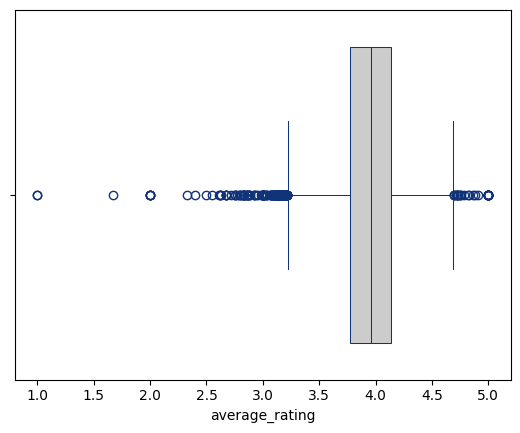

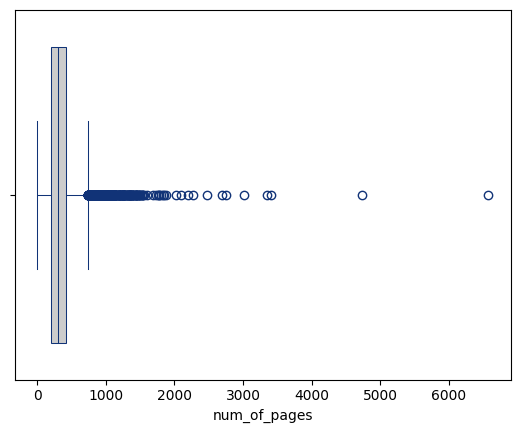

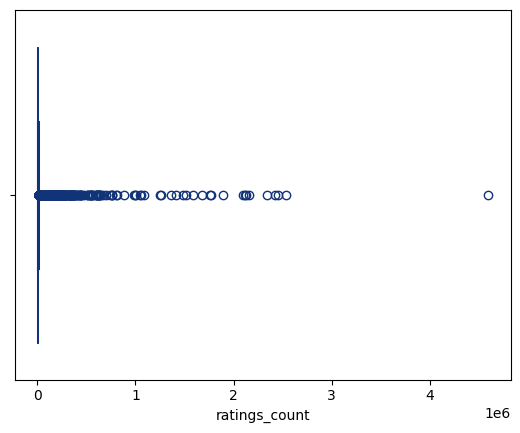

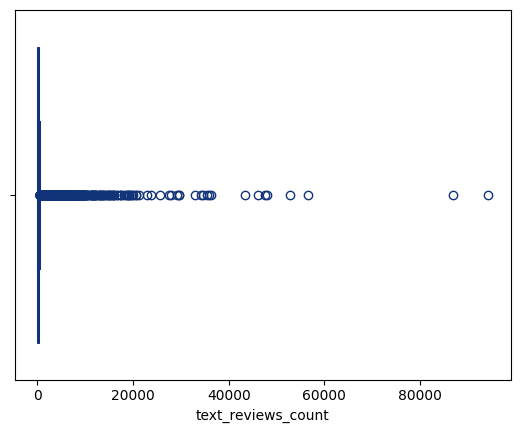

In [ ]:
numerical_feature = ['average_rating','num_of_pages','ratings_count','text_reviews_count']
for feature in numerical_feature:
  sns.boxplot(data=book, x=feature, color=".8", linecolor="#137", linewidth=.75)
  plt.show()

Berdasarkan output kode di atas, terlihat bahwa terdapat outliers pada data dari fitur 'average_rating', 'num_of_pages', 'ratings_count', dan 'text_reviews_count'.

Outlier tersebut diatasi dengan menggunakan z-score. Nilai z-score dari masing-masing record pada fitur dihitung menggunakan rumusan berikut.

$$z = \frac{x - \mu}{\sigma}$$

dengan:
- $z$ = nilai data yang dihitung z-score-nya.
- $x$ = nilai data.
- $\mu$ = nilai rata-rata
- $\sigma$ = standar deviasi.

Nilai z-score tersebut bisa dihitung menggunakan fungsi zscore() dari library stats. Pada kode dibawah ini, diterapkan threshold bernilai 3, yang berarti data dengan nilai z-score lebih dari 3 diasumsikan sebagai outlier sehingga dihilangkan dari dataset.

In [ ]:
z = np.abs(stats.zscore(book[['average_rating','num_of_pages','ratings_count','text_reviews_count']]))

# Data dengan z-score kurang dari sama dengan 3 dipertahankan pada dataset
# Atau dengan kata lain data dengan z-score lebih dari 3 dihilangkan dari dataset
book_clean = book[(z<=3).all(axis=1)]

book_clean = book_clean.reset_index(drop=True)
book_clean.shape

(9902, 7)

Terlihat dataset terbaru yang terdiri dari 9902 record (pengamatan) dan 7 kolom.

### **Analisis Univariat**

Pada tahap ini dilakukan analisis univariat untuk mengetahui dan mengidentifikasi karakteristik dari setiap fitur.

#### a. Fitur Kategori

Pertama, dilakukan analisis univariat terhadap fitur kategori sebagai berikut.

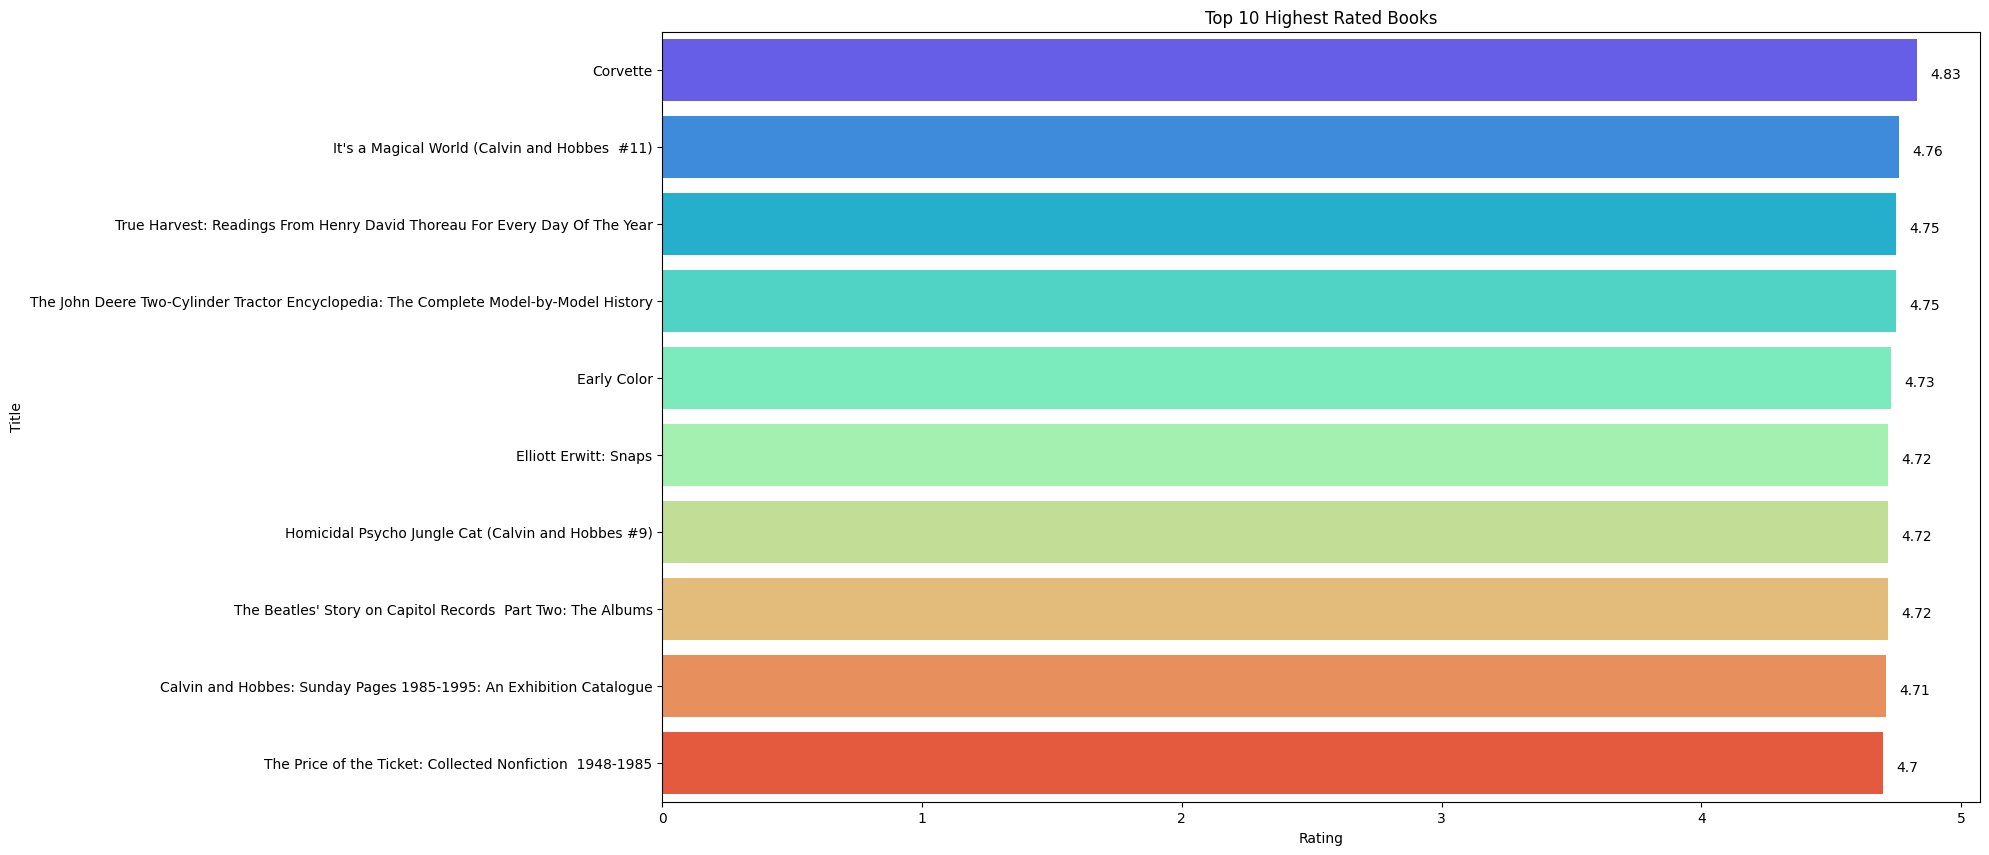

In [ ]:
top_average_rating = book_clean.sort_values(by='average_rating', ascending=False).head(10)

plt.figure(figsize=(17,10))
ax = sns.barplot(x='average_rating',
            y='title',
            data=top_average_rating,
            palette=sns.color_palette('rainbow',10))
ax.set(title='Top 10 Highest Rated Books',
       xlabel='Rating',
       ylabel='Title')

for i in ax.patches:
    ax.text(i.get_width() + 0.05,
            i.get_y() + 0.5,
            str(i.get_width()),
            fontsize = 10,
            color='black')
plt.show()

Berdasarkan grafik atas, diketahui bahwa:
- Buku 'The John Deere Two-Cylinder Tractor Encyclopedia: The Complete Model by Model History' menjadi dengan nilai peringkat tertinggi.
- Top 10 buku dengan nilai peringkat tertinggi mempunyai nilai rating yang tidak jauh berbeda, yang masing-masing nilai peringkat berkisar antara 4.7-4.83.

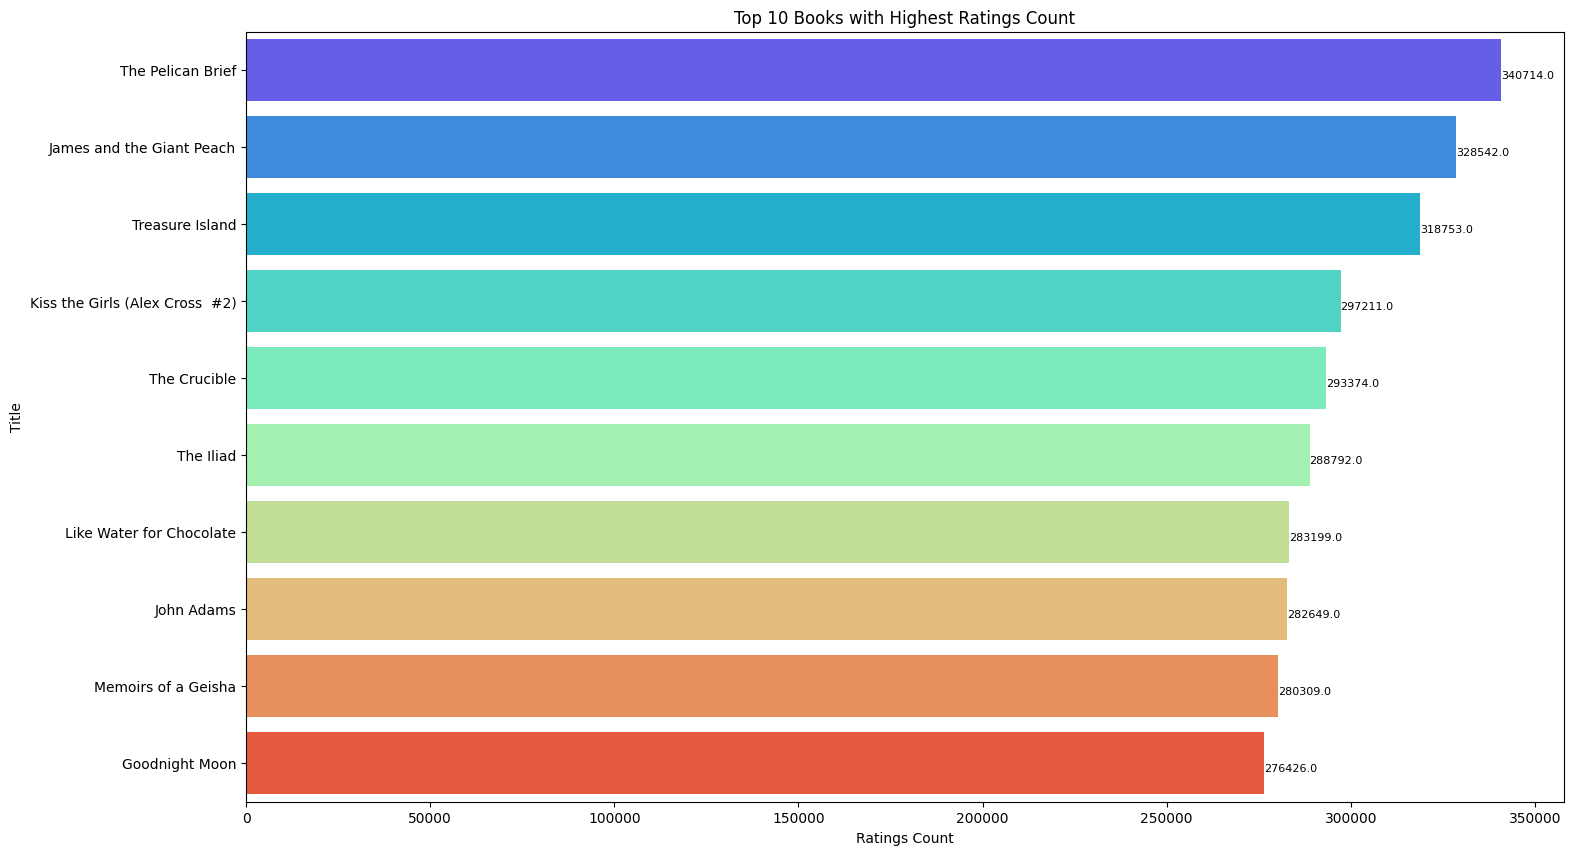

In [ ]:
top_ratings_count = book_clean.sort_values(by='ratings_count', ascending=False).head(10)

plt.figure(figsize=(17,10))
ax = sns.barplot(x='ratings_count',
                 y='title',
                 data=top_ratings_count,
                 palette=sns.color_palette('rainbow',10))
ax.set(title='Top 10 Books with Highest Ratings Count',
       xlabel='Ratings Count',
       ylabel='Title')

for i in ax.patches:
    ax.text(i.get_width() + 0.05,
            i.get_y() + 0.5,
            str(i.get_width()),
            fontsize = 8,
            color='black')
plt.show()

Berdasarkan grafik di atas, diketahui bahwa:
 1. Buku 'The Pelican Grief' menjadi buku yang paling banyak dinilai peringkatnya oleh pengguna goodreads.
 2. Top 10 buku yang paling banyak dinilai peringkatnya mempunyai nilai rating yang berkisar antara 270-350 ribu peringkat.

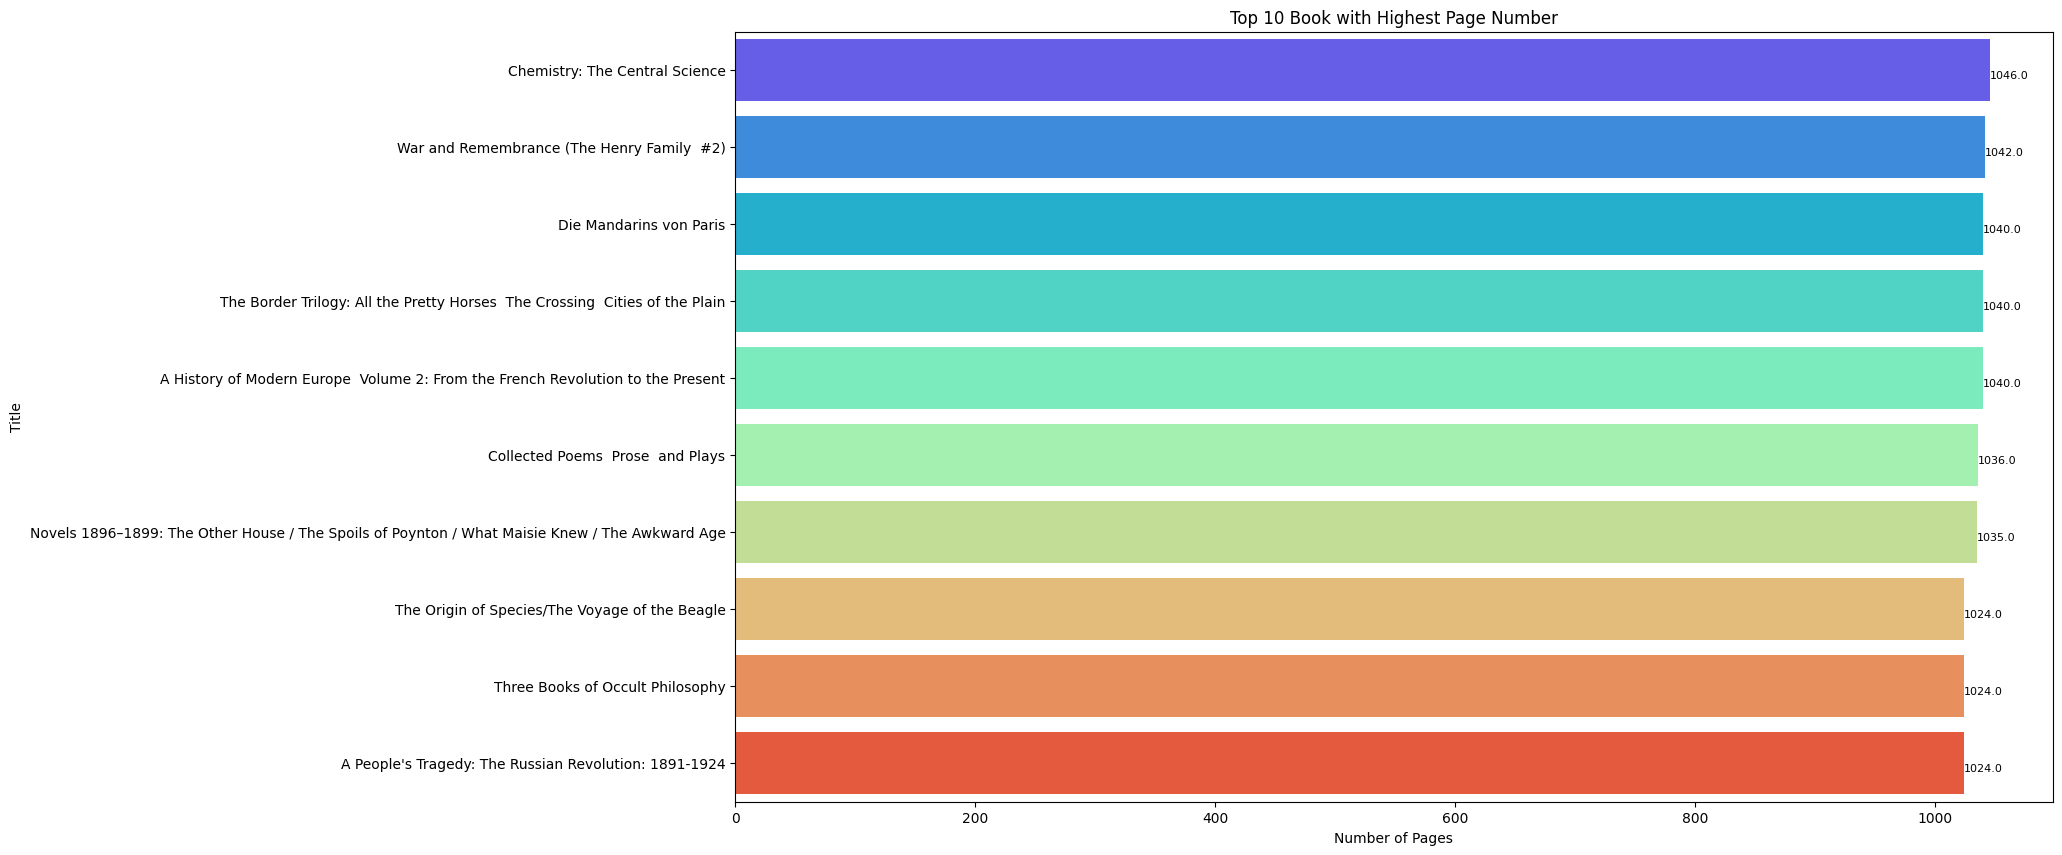

In [ ]:
top_num_of_pages = book_clean.sort_values(by='num_of_pages', ascending=False).head(10)

plt.figure(figsize=(17,10))
ax = sns.barplot(x='num_of_pages',
                 y='title',
                 data=top_num_of_pages,
                 palette=sns.color_palette('rainbow',10))
ax.set(title='Top 10 Book with Highest Page Number',
       xlabel='Number of Pages',
       ylabel='Title')

for i in ax.patches:
    ax.text(i.get_width() + 0.05,
            i.get_y() + 0.5,
            str(i.get_width()),
            fontsize = 8,
            color='black')
plt.show()

Berdasarkan grafik di atas, diketahui bahwa:
1. Buku 'Chemistry: The Central Science' menjadi buku dengan jumlah halaman terbanyak.
2. Top 10 buku dengan jumlah halaman terbanyak mempunyai jumlah halaman yang tidak jauh berbeda, yang masing-masing nilainya berkisar antara 1024-1046 halaman.

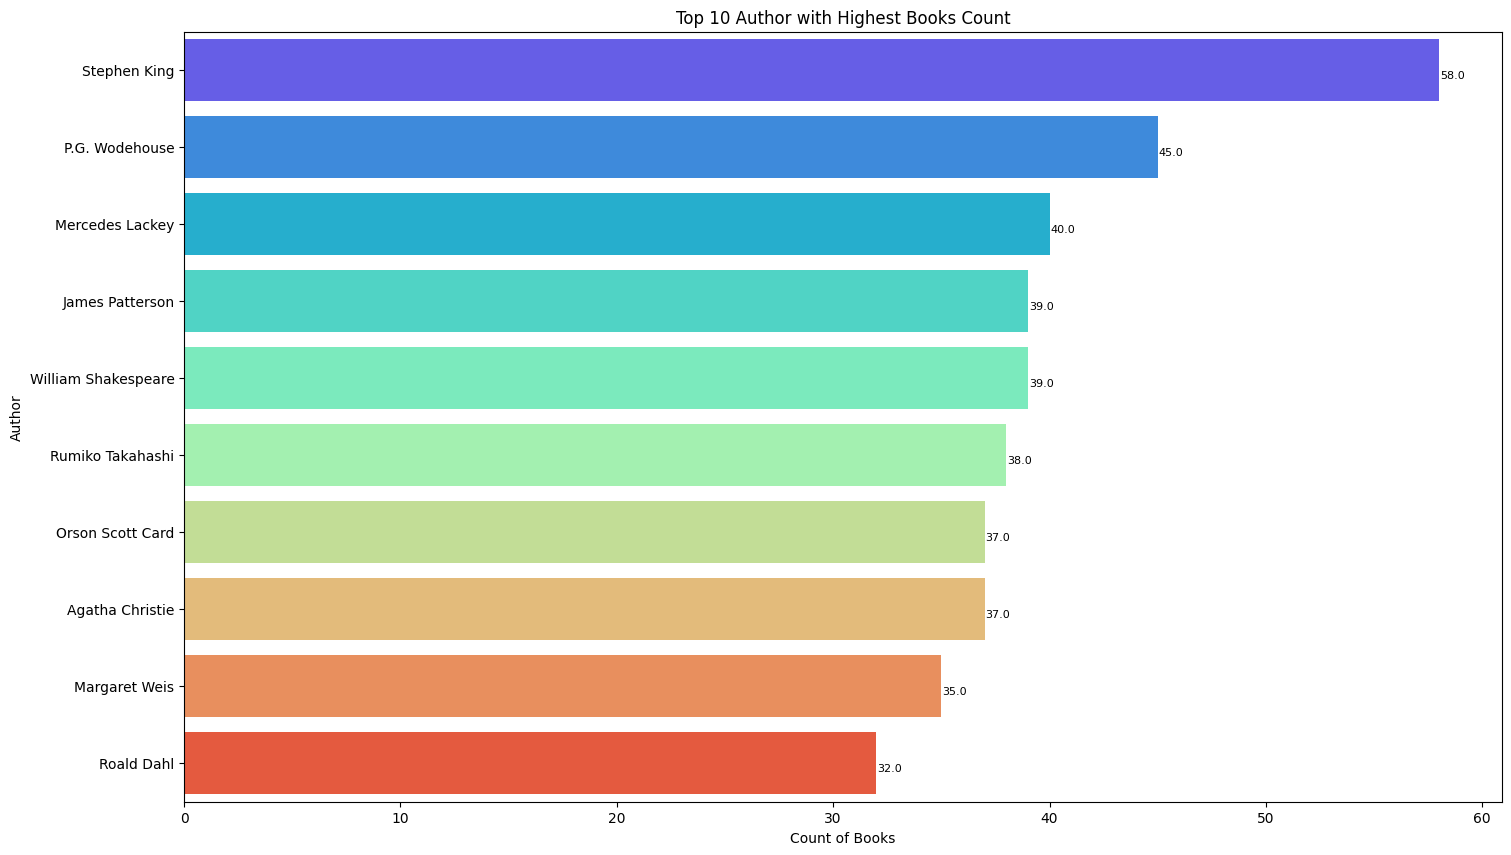

In [ ]:
count = book_clean['only_author'].value_counts().head(10)
author = count.index
df_categorical_author = pd.DataFrame({'only_author':author,'count':count})
df_categorical_author.reset_index(drop=True, inplace=True)

plt.figure(figsize=(17,10))
ax = sns.barplot(x='count',
                 y='only_author',
                 data=df_categorical_author,
                 palette=sns.color_palette('rainbow',10))
ax.set(title='Top 10 Author with Highest Books Count',
       xlabel='Count of Books',
       ylabel='Author')

for i in ax.patches:
    ax.text(i.get_width() + 0.05,
            i.get_y() + 0.5,
            str(i.get_width()),
            fontsize = 8,
            color='black')
plt.show()

Berdasarkan grafik di atas, diketahui bahwa:
1. Stephen King menjadi penulis dengan total buku terbanyak, yaitu 58 buku.
2. Top 10 penulis dengan total buku terbanyak mempunyai nilai total buku berkisar antara 32-58 buku.

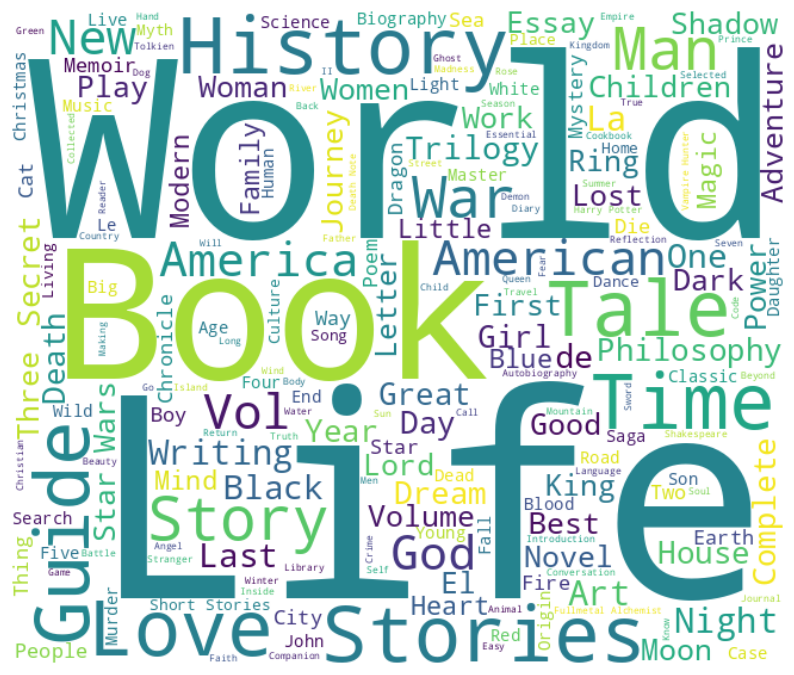

In [ ]:
text_of_title = " ".join(title for title in book_clean['title'])
wordcloud = WordCloud(background_color='white',
                      width=650,
                      height=550,
                      stopwords=set(STOPWORDS)).generate(text_of_title)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

Berdasarkan output kode di atas, terlihat bahwa kata yang sering digunakan dalam judul buku, yaitu Life, Book, World, History, Tale, Guide dst.

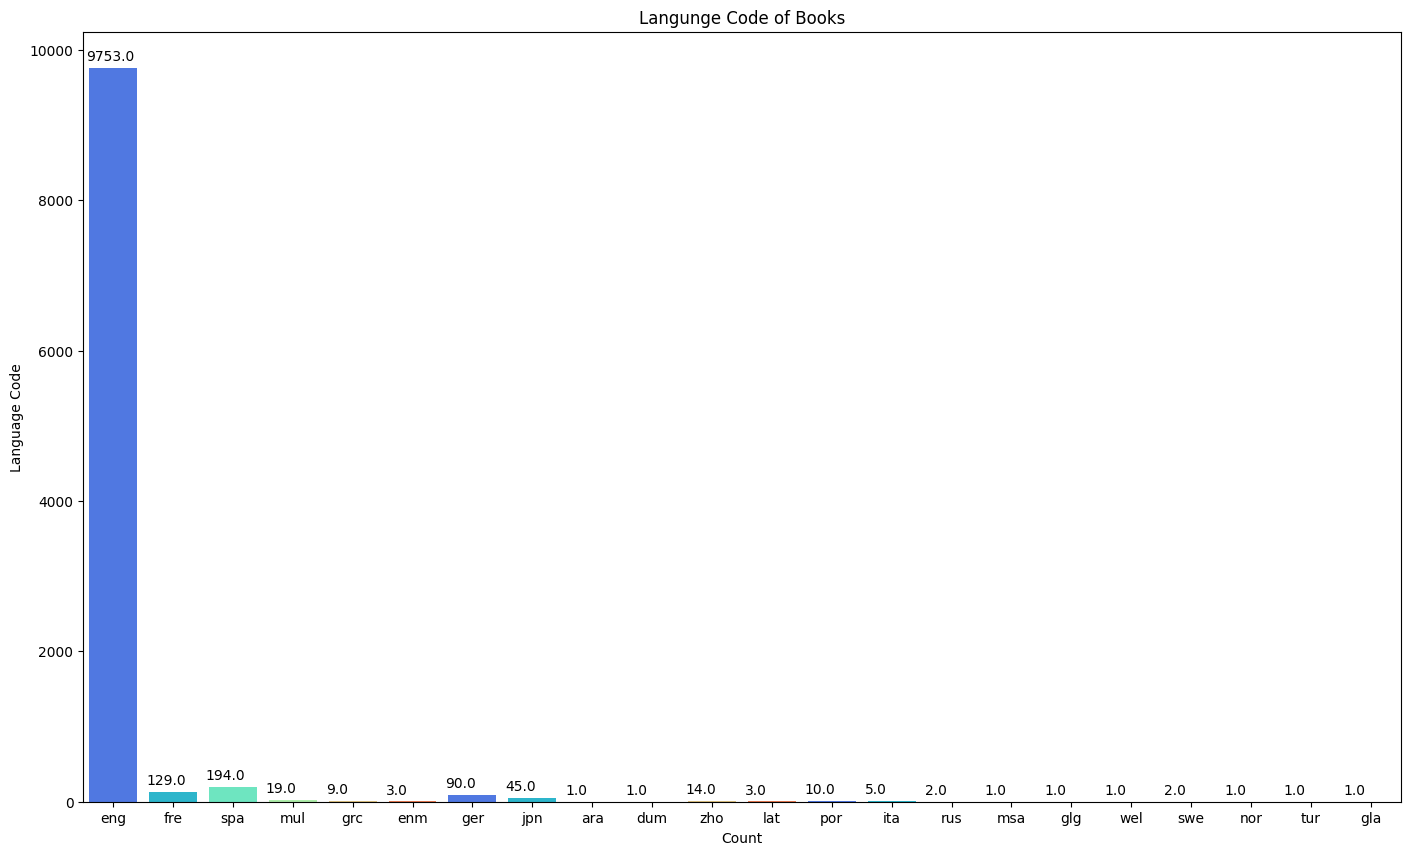

In [ ]:
plt.figure(figsize=(17,10))
ax = sns.countplot(x='language_code',
                 data=book,
                 palette=sns.color_palette('rainbow'))
ax.set(title='Langunge Code of Books',
       xlabel='Count',
       ylabel='Language Code')

for i in ax.patches:
    ax.annotate(str(i.get_height()),
                (i.get_x()-0.05, i.get_height()+100),
                fontsize = 10,
                color='black')

plt.show()

Berdasarkan grafik di atas, terlihat bahwa sebagian besar buku berbahasa Inggris.

#### b. Fitur Numerik

Selanjutnya, dilakukan analisis univariat terhadap fitur numerik sebagai berikut.

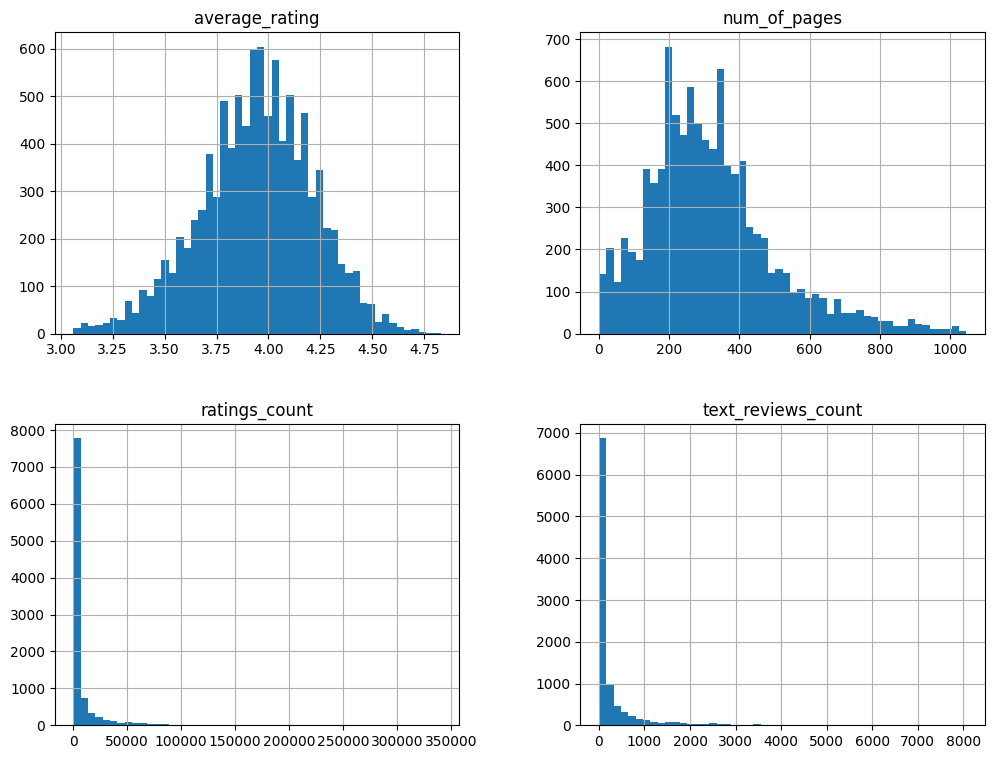

In [ ]:
book_clean.hist(bins=50, figsize=(12,9))
plt.show()

Diperhatikan histogram di atas, diperoleh bahwa:
- Distribusi 'average_rating' cenderung mendekati distribusi normal.
- Distribusi 'num_of_pages', 'ratings_count', dan text_reviews_count' cenderung miring ke kanan.
- Nilai 'ratings_count' sebagian besar berada pada rentang 0-50.000. Di lain hal, nilai 'text_reviews_count' sebagian besar berada pada rentang 0-1000.

## **Data Preparation**

Proses Data Cleaning yang sudah dilakukan sebelumnya merupakan bagian dari Data Preparation. Masih ada dua tahap lagi dari Data Preparation yang perlu dilakukan, yaitu:
2. Data Preparation untuk Sistem Rekomendasi Content-Based Filtering menggunakan teknik Cosine Similarity yang meliputi representasi fitur.
3. Data Preparation untuk Sistem Rekomendasi Collaborative Filterin menggunakan algoritma KNN yang meliputi reduksi fitur dan scaling fitur numerik.

### **1. Data Preparation untuk Sistem Rekomendasi Content-Based Filtering**

Sistem Rekomendasi Content-Based Filtering menggunakan teknik Cosine Similarity yang akan dibangun tersebut akan memakai fitur 'language_code' dan 'only_author' sebagai filternya. Untuk membuat sistem rekomendasi tersebut, kedua fitur tersebut perlu direpresentasikan menjadi matriks yang dibentuk dari vektor-vektor tf-idf. Oleh karena itu, berikut ini akan dilakukan representasi fitur 'language_code' dan 'only_author' tersebut.

#### Representasi Fitur 'language_code'

Pertama, dibentuk terlebih dahulu vektor tf-idf dari fitur 'language_code' menggunakan fungsi tfidfvectorizer() dari library sklearn. Diimplementasikan kode berikut.

In [ ]:
tf_lc = TfidfVectorizer()
tf_lc.fit(book_clean['language_code'])
tf_lc.get_feature_names_out()

array(['ara', 'dum', 'eng', 'enm', 'fre', 'ger', 'gla', 'glg', 'grc',
       'ita', 'jpn', 'lat', 'msa', 'mul', 'nor', 'por', 'rus', 'spa',
       'swe', 'tur', 'zho'], dtype=object)

Selanjutnya, dilakukan fit dan transformasi vektor tf-idf tersebut ke dalam bentuk matriks.

In [ ]:
tfidf_lc_matrix = tf_lc.fit_transform(book_clean['language_code'])
tfidf_lc_matrix.shape

(9902, 21)

Berdasarkan output kode di atas diperoleh bahwa matriks tersebut berukuran (9902, 21). Nilai 9902 merupakan ukuran data dan 21 merupakan metrik kategori kode bahasa (language_code). Selanjutnya, untuk menghasilkan vektor tf-idf dalam bentuk matriks, digunakan fungsi todense() sebagai berikut.

In [ ]:
tfidf_lc_matrix.todense()

matrix([[0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        ...,
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 1., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

Ditampilkan matriks tf-idf untuk beberapa judul buku (title) dan kategori kode bahasa (language_code) dengan mengimplementasikan kode berikut.

In [ ]:
tfidf_lc_matrix_df = pd.DataFrame(
    tfidf_lc_matrix.todense(),
    columns=tf_lc.get_feature_names_out(),
    index=book_clean.title
).sample(10, axis=1).sample(10, axis=0)
tfidf_lc_matrix_df

,grc,ara,por,eng,jpn,rus,ger,ita,nor,gla
title,,,,,,,,,,
The Complete Book of Home Site and Office Security: Selecting Installing and Troubleshooting Systems and Devices,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Alles ist erleuchtet,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
What Was She Thinking? [Notes on a Scandal],0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Una breve historia de casi todo,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Presocratic Philosophy: A Very Short Introduction,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
The Rise of Christianity : A Sociologist Reconsiders History,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Norse Mythology: A Guide to the Gods Heroes Rituals and Beliefs,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Honey (Shooting Stars #4),0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
Portrait in Death (In Death #16),0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Dengan menggunakan output di atas, dapat dilakukan identifikasi korelasi antara judul buku dan kode bahasa. Diperhatikan bahwa angka 1.0 pada output dari kode di atas mengindikasikan bahwa judul buku pada kolom X (horizontal) mempunyai kode bahasa pada baris Y (vertikal).

Sampai di sini, telah berhasil dilakukan representasi fitur kode bahasa dengan fungsi tfidfvectorizer. Lebih lanjut, juga telah dibuat matriks yang menunjukkan korelasi antara judul buku dengan kode bahasa.

#### Representasi Fitur 'only_author'

Dengan cara analog seperti di atas, dijalankan kode berikut ini untuk merepresentasikan fitur penulis (only_author) kedalam bentuk vektor tf-idf. Lebih lanjut, juga dibuat matriks yang menunjukkan korelasi antara penulis (only_author) dengan buku dalam kode di bawah.

In [ ]:
tf_a = TfidfVectorizer()
tf_a.fit(book_clean['only_author'])
tf_a_idf_matrix = tf_a.fit_transform(book_clean['only_author'])

Kedua matriks hasil representasi fitur di atas, yaitu:
1. 'tf_lc_idf_matrix', yaitu matriks yang menunjukkan korelasi antara kode bahsa (language_kode) dengan buku,
2. 'tf_a_idf_matrix, yaitu matriks yang menunjukkan korelasi antara penulis (only_author) dengan buku,

akan digunakan pada tahap modeling dengan teknik cosine similarity.


### **2. Data Preparation untuk Sistem Rekomendasi Collaborative Filtering**

Data preparation untuk sistem rekomendasi colaborative filtering meliputi:
1. Reduksi Fitur
2. Scaling

#### Reduksi Fitur

Pertama, dibuat dataframe baru dengan menghapus fitur-fitur yang tidak diperlukan untuk membuat sistem rekomendasi collaborative filtering, yaitu 'language_code' dan 'only_author'. Diimpelemtasikan kode berikut.

In [ ]:
book_cf = book_clean.drop(['language_code','only_author'], axis=1)
book_cf.head()

,title,average_rating,num_of_pages,ratings_count,text_reviews_count
0,Harry Potter and the Chamber of Secrets (Harry...,4.42,352,6333,244
1,"Unauthorized Harry Potter Book Seven News: ""Ha...",3.74,152,19,1
2,The Ultimate Hitchhiker's Guide: Five Complete...,4.38,815,3628,254
3,The Ultimate Hitchhiker's Guide to the Galaxy ...,4.38,815,249558,4080
4,The Hitchhiker's Guide to the Galaxy (Hitchhik...,4.22,215,4930,460


Selanjutnya, 'title' dijadikan sebagai indeks dataframe tersebut dengan mengimplementasikan kode berikut.

In [ ]:
book_cf.set_index('title', inplace=True)
book_cf.head()

,average_rating,num_of_pages,ratings_count,text_reviews_count
title,,,,
Harry Potter and the Chamber of Secrets (Harry Potter #2),4.42,352,6333,244
"Unauthorized Harry Potter Book Seven News: ""Half-Blood Prince"" Analysis and Speculation",3.74,152,19,1
The Ultimate Hitchhiker's Guide: Five Complete Novels and One Story (Hitchhiker's Guide to the Galaxy #1-5),4.38,815,3628,254
The Ultimate Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy #1-5),4.38,815,249558,4080
The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy #1),4.22,215,4930,460


#### Scaling

Pada proses scaling ini, digunakan teknik MixMaxScaler dari library ScikitLearn. MinMaxScaler melakukan standardisasi dengan mengurangkan nilai data, lalu membaginya dengan selisih dari nilai minimum dan nilai maksimum data, yaitu

$x = \frac{x - x_{min}}{x_{max} - x_{min}}$

dengan:
* $x$ = nilai data yang di-scaling
* $x_{min}$ = nilai data minimum dari keseluruhan data pada fitur
* $x_{min}$ = nilai data maksimum dari keseluruhan data pada fitur


Dilakukan scaling dengan teknik MixMaxscaler dengan mengimplementasikan kode berikut.

In [ ]:
numerical_features = ['average_rating','num_of_pages','ratings_count','text_reviews_count']

scaler = MinMaxScaler()
scaler.fit(book_cf[numerical_features])

book_cf[numerical_features] = scaler.transform(book_cf.loc[:, numerical_features])
book_cf[numerical_features].head()

,average_rating,num_of_pages,ratings_count,text_reviews_count
title,,,,
Harry Potter and the Chamber of Secrets (Harry Potter #2),0.768362,0.335885,0.018585,0.030243
"Unauthorized Harry Potter Book Seven News: ""Half-Blood Prince"" Analysis and Speculation",0.384181,0.144498,0.000053,0.000124
The Ultimate Hitchhiker's Guide: Five Complete Novels and One Story (Hitchhiker's Guide to the Galaxy #1-5),0.745763,0.778947,0.010645,0.031482
The Ultimate Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy #1-5),0.745763,0.778947,0.732455,0.505702
The Hitchhiker's Guide to the Galaxy (Hitchhiker's Guide to the Galaxy #1),0.655367,0.204785,0.014467,0.057015


## **Model Development**

Pada tahap ini, dilakukan pengembangan model yaitu, yaitu
1. Model Content-Based Filtering menggunakan cosine similarity.
2. Model Collaborativr Filtering menggunakan algoritma KNN.

### **1. Model Content-Based Filtering**

Model content-based filtering yang dikembangkan meliputi:
1. Cosine similarity (dengan filter 'language_code')
2. Cosine similarity (dengan filter 'only_author')

#### Cosine similarity (dengan filter 'language_code')


Pertama dihitung derajat kesamaan nilai antar judul buku. Untuk itu, digunakan fungsi cosine_similarity dari library sklearn dengan input berupa data korelasi antara judul buku dan kategori kode bahasa, yaitu dataframe 'cosine_sim_lc' yang sudah dibuat pada tahap sebelumnya. Diimplementasikan kode berikut.

In [ ]:
cosine_sim_lc = cosine_similarity(tfidf_lc_matrix)
cosine_sim_lc

array([[1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       ...,
       [1., 1., 1., ..., 1., 1., 0.],
       [1., 1., 1., ..., 1., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

Selanjutnya, ditampilkan matriks kesamaan setiap buku dengan menampilkan judul buku dalam 5 sampel kolom (axis = 1) dan 10 sampel baris (axis=0) dengan menjalankan kode berikut.

In [ ]:
cosine_sim_lc_df = pd.DataFrame(cosine_sim_lc, index=book_clean['title'], columns=book_clean['title'])
print('Shape:', cosine_sim_lc_df.shape)
cosine_sim_lc_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9902, 9902)


title,From Glencoe to Stirling: Rob Roy the Highlanders & Scotlands Chivalric Age (Tales of a Scottish Grandfather 3),The Return of the Shadow: The History of The Lord of the Rings Part One (The History of Middle-Earth #6),The Beatles Complete - Updated Edition,Many Luscious Lollipops: A Book About Adjectives,Schattenkuss (Meredith Gentry #1)
title,,,,,
Black Beauty (Coloring Book),1.0,1.0,1.0,1.0,0.0
The Best of the Spirit,1.0,1.0,1.0,1.0,0.0
Jerusalem Inn (Richard Jury #5),1.0,1.0,1.0,1.0,0.0
A Time to Embrace: Same-Gender Relationships in Religion Law and Politics,1.0,1.0,1.0,1.0,0.0
Artesia Volume 1,1.0,1.0,1.0,1.0,0.0
The Stranger,1.0,1.0,1.0,1.0,0.0
Tuesdays with Morrie,1.0,1.0,1.0,1.0,0.0
Practical DV Filmmaking,1.0,1.0,1.0,1.0,0.0
Veronika Decides to Die,1.0,1.0,1.0,1.0,0.0


 Output kode di berupa data kesamaan antar judul buku. Diperhatikan bahwa angka 1.0 pada output dari kode di atas mengindikasikan bahwa restoran pada kolom X (horizontal) memiliki kesamaan dengan restoran pada baris Y (vertikal).

Selanjutnya, berikut ini dibuat fungsi resto_recommendations_lc yang digunakan untuk memberikan rekomendasi buku (dengan filter 'language_code').

In [ ]:
def book_recommendations_lc(title, similarity_data=cosine_sim_lc_df, items=book_clean[['title', 'language_code']], k=5):

    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,title].to_numpy().argpartition(range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop title agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Dijalankan fungsi di atas untuk menemukan rekomendasi buku yang mirip dengan buku 'La Place de la Concorde Suisse' dengan kode bahasa 'fre', yang berarti berbahasa prancis, sebagai berikut.

In [ ]:
book_recommendations_lc('La Place de la Concorde Suisse')

,title,language_code
0,Bright Lights Big City,fre
1,La Petite Fille du Lac,fre
2,L'Épée de Darwin,fre
3,Les Fils des ténèbres,fre
4,Da Vinci Code (Robert Langdon #2),fre


Sistem rekomendasi yang dibuat berhasil memberikan rekomendasi 5 judul buku lainnya yang berbahasa prancis.

Dengan langkah analog seperti di atas, berikut ini dilakukan pembangunan model content-based filtering menggunakan cosine similarity dengan filter penulis (only_author).

#### Cosine similarity (dengan filter 'only_author')

Dengan langkah analog seperti di atas, dihitung derajat kesamaan nilai antar judul buku mengggunakan teknik cosine similarity dengan input berupa data korelasi antara judul buku dan kategori penulis, yaitu dataframe 'tf_a_idf_matrix' yang sudah dibuat pada tahap sebelumnya. Lebih lanjut, dibuat juga fungsi rekomendasinya.

In [ ]:
cosine_sim_a = cosine_similarity(tf_a_idf_matrix)
cosine_sim_a_df = pd.DataFrame(cosine_sim_a, index=book_clean['title'], columns=book_clean['title'])

def book_recommendations_t(title, similarity_data=cosine_sim_a_df, items=book_clean[['title', 'only_author']], k=5):

    # Mengambil data dengan menggunakan argpartition untuk melakukan partisi secara tidak langsung sepanjang sumbu yang diberikan
    # Dataframe diubah menjadi numpy
    # Range(start, stop, step)
    index = similarity_data.loc[:,title].to_numpy().argpartition(
        range(-1, -k, -1))

    # Mengambil data dengan similarity terbesar dari index yang ada
    closest = similarity_data.columns[index[-1:-(k+2):-1]]

    # Drop title agar nama resto yang dicari tidak muncul dalam daftar rekomendasi
    closest = closest.drop(title, errors='ignore')

    return pd.DataFrame(closest).merge(items).head(k)

Diterapkan fungsi di atas untuk menemukan rekomendasi buku yang mirip dengan buku 'The Passion' karya Jeanette Winterson sebagai berikut.

In [ ]:
book_recommendations_t('The Passion')

,title,only_author
0,Art and Lies,Jeanette Winterson
1,Sexing the Cherry,Jeanette Winterson
2,Art Objects: Essays on Ecstasy and Effrontery,Jeanette Winterson
3,Lighthousekeeping,Jeanette Winterson
4,Written on the Body,Jeanette Winterson


Sistem rekomendasi yang dibuat berhasil memberikan rekomendasi 5 judul buku yang ditulis oleh Jeanette Winterson.

### **2. Model Collaborative Filtering menggunakan KNN**

Berikut ini dibuat model KNN dengan metrik 'euclidean' yang penghitung kedekatan antar data.

In [ ]:
knn = NearestNeighbors(metric='euclidean')
knn.fit(book_cf)

NearestNeighbors(metric='euclidean')

Selanjutnya, dibuat dataframe yang hanya berisikan judul buku saja sebagai berikut.

In [ ]:
book_title = pd.DataFrame({'title':book_clean['title']})
book_title.head()

,title
0,Harry Potter and the Chamber of Secrets (Harry...
1,"Unauthorized Harry Potter Book Seven News: ""Ha..."
2,The Ultimate Hitchhiker's Guide: Five Complete...
3,The Ultimate Hitchhiker's Guide to the Galaxy ...
4,The Hitchhiker's Guide to the Galaxy (Hitchhik...


Kemudian dibuat fungsi rekomendasi yang memanfaatkan skor distance dari model knn sebagai berikut.

In [ ]:
def book_recommendation_cf(booktitle, k=6):

  distances, neighbors = knn.kneighbors(book_cf.loc[booktitle].to_numpy().reshape(1, -1), n_neighbors=k)

  similar_book = []
  for title in book_title.loc[neighbors[0][:]].values:
    similar_book.append(title[0])
  del similar_book[0]

  similar_distance = []
  for distance in distances[0]:
    similar_distance.append(f"{round(100-distance, 2)}%")
  del similar_distance[0]

  return pd.DataFrame(data = {"Book Title" : similar_book, "Similiarity Score" : similar_distance})

Dilakukan uji coba fungsi di atas untuk merekomendasikan buku-buku yang mempunyai kesamaan dengan buku 'The Untouchables' sebagai berikut.

In [ ]:
book_recommendation_cf('The Untouchables')

,Book Title,Similiarity Score
0,Philosophy: The Classics,100.0%
1,The Odes,100.0%
2,Pyramids of Montauk: Explorations in Conscious...,100.0%
3,Buddhism: A Concise Introduction,99.99%
4,Sliding Scales (Pip & Flinx #10),99.99%


Sistem rekomendasi yang dibuat berhasil memberikan rekomendasi 5 judul buku yang serupa dengan 'The Untouchables' tingkat kemiripan 99.9%-100%.

## **Evaluasi Model**

### **1. Precision**

Model Content Based-Filtering menggunakan teknik Cosine Similarity dievaluasi menggunakan metrik precision (presisi). Untuk sistem rekomendasi, rumusan metrik presisi diberikan sebagai berikut.

$$ Precision = \frac{Rel}{Rec} \times 100\%, $$
dengan:
- $Rel$ = banyak item hasil rekomendasi yang relevan.
- $Rec$ = banyak item hasil rekomendasi.

Berdasarkan uji coba Model Content Based-Filtering menggunakan teknik Cosine Similarity di atas, diperoleh bahwa $\frac{5}{5}$ hasil rekomendasi mempunyai kode bahasa atau penulis yang serupa dengan buku yang digunakan oleh pengguna. Oleh karena itu, diperoleh Model Content Based-Filtering menggunakan teknik Cosine Similarity Similarity mempunyai presisi sebesar $\frac{5}{5} \times 100 \% = 100\%$.


### **2. Davies-Bouldien Score**

Model Collaborative Filtering menggunakan algoritma KNN dievaluasi menggunakan metrik Davies-Bouldin Score, yaitu metrik evaluasi yang digunakan untuk mengukur kualitas pengelompokan dalam analisis klaster. Skor ini mengukur seberapa baik sebuah klaster dipisahkan satu sama lain dan seberapa serupa objek dalam klaster yang sama. Semakin rendah nilai Davies-Bouldin Score, semakin baik separasi tiap kluster yang dihasilkan model.

Berikut ini diimplementasikan kode untuk menghitung Davies-Bouldin Score dari Model Collaborative Filtering menggunakan algoritma KNN yang telah dibangun sebelumnya.

In [ ]:
db_score = davies_bouldin_score(book_cf, book_title)
print(db_score)

3.8725434409129003


Berdasarkan output di atas, diperoleh Davies-Bouldin Score yang cukup kecil. Hal tersebut mengindikasikan bahwa separasi tiap kluster yang dihasilkan model cukup baik.